# Introduction
This notebook provides a quick learning resource for manipulating image data with OpenCV, following the Basics and Advanced sections of this youtube video: https://www.youtube.com/watch?v=oXlwWbU8l2o

Images of the Sun are used as examples, which can be downloaded for a given year, e.g. 2021, using a link similar to the following: https://spaceweather.com/images2021/. Of course, any image will do, just place the image file(s) in a folder on your file system, and provide the appropriate data_dir and image_files string values below. It is helpful to have several different images to test with.

## References
- https://pypi.org/project/opencv-python/
- https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
- https://forums.developer.nvidia.com/t/python-what-is-the-four-characters-fourcc-code-for-mp4-encoding-on-tx2/57701/6
- https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
- https://docs.opencv.org/4.5.1/d9/d8b/tutorial_py_contours_hierarchy.html
- 

In [1]:
# Import packages
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Set parameters
# data_dir: a string containing the directory where image files are located
# image_files: a list containing strings, with each string specifying the name of an image file, including extension
# image_index: an integer that specifies which image_file value to analyze in the code blocks below
# Note that os.listdir or glob could also be used to obtain a list of all files in data_dir
data_dir = "/home/fdpearce/Documents/Projects/data/Images/Sun/"
image_files = ["20aug21_hmi4096_blank.jpg", "21aug21_hmi4096_blank.jpg", "22aug21_hmi4096_blank.jpg", "23aug21_hmi4096_blank.jpg", \
               "24aug21_hmi4096_blank.jpg", "25aug21_hmi4096_blank.jpg", "26aug21_hmi4096_blank.jpg", "27aug21_hmi4096_blank.jpg", \
               "28aug21_hmi4096_blank.jpg", "29aug21_hmi4096_blank.jpg", "30aug21_hmi4096_blank.jpg", "31aug21_hmi4096_blank.jpg", \
               "01sep21_hmi4096_blank.jpg", "02sep21_hmi4096_blank.jpg", "03sep21_hmi4096_blank.jpg", "04sep21_hmi4096_blank.jpg", \
               "05sep21_hmi4096_blank.jpg"]
image_index = 0

In [3]:
# Define functions
def resize_frame(frame, scale=0.5, interp_method = cv.INTER_AREA):
    width = int(frame.shape[1]*scale)
    height = int(frame.shape[0]*scale)
    return cv.resize(frame, (width, height), interpolation=interp_method)

def translate_frame(frame, x, y):
    """Translate an image frame by pixel values (x, y) where
    -x value ---> Left
    -y value ---> Up
    x value ---> Right
    y value ---> Down
    """
    trans_mat = np.float32([[1, 0, x], [0, 1, y]])
    dimensions = (frame.shape[1], frame.shape[0])
    return cv.warpAffine(frame, trans_mat, dimensions)

def rotate_frame(frame, rotation_angle, rotation_point=None):
    """Rotate an image frame by rotation_angle degrees where
    -rotation_angle value ---> clockwise
    """
    h, w = frame.shape[:2]
    if rotation_point is None:
        rotation_point = (w//2, h//2)
    rotation_matrix = cv.getRotationMatrix2D(rotation_point, rotation_angle, 1.0)
    return cv.warpAffine(frame, rotation_matrix, (w, h))

def flip_frame(frame, flip_code):
    """Flip an image frame using flip_code where
    flip_code = 0 ---> vertical
    flip_code = 1 ---> horizontal
    flip_code = -1 ---> both vertical and horizontal
    """
    return cv.flip(frame, flip_code)

# See www.pyimagesearch.com link in References
def edges_canny_auto(frame, median_ratio=0.33):
    m = np.median(frame)
    l = int(max(0, (1.0-median_ratio)*m))
    h = int(min(255, (1.0-median_ratio)*m))
    return cv.Canny(frame, l, h)

def print_frame_info(frame, frame_desc=""):
    print(f"{frame_desc} Image Shape: Height={frame.shape[0]}, Width={frame.shape[1]}, Channels={frame.shape[2]}")

def show_frame(frame, frame_title):
    cv.imshow(frame_title, frame)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
def get_hist_params(hist_params, plot_params=None):
    """Return a dictionary containing parameters for calculating and plotting histograms using OpenCV. This
    function defines default parameter values, then updates them based on user input to the function, and finally
    it does error checking to identify incomplete or erroneous input parameters from the user.
    """
    # Default values for all parameters, except 'images', which MUST be provided by user
    params = {
        'hist': {
            'images': None,
            'channels': [0],
            'mask': None,
            'histSize': [256],
            'ranges': [0, 256]
        },
        'plot': {
            'figsize': (10, 8),
            'title': "Image Histogram",
            'xlabel': "Bins",
            'ylabel': "# of Pixels",
            # Specify color code for each channel: MUST have same length as hist 'channels' list above
            'channel_colors': ["k"]
        }
    }
    if 'images' not in hist_params:
        raise KeyError("Missing 'images' key containing a list of images, the only required key/value pair in hist_params")
    # Update param dicts based on user input
    if hist_params:
        try:
            params['hist'].update(hist_params)
        except Exception as e:
            print(e)
    if plot_params:
        try:
            params['plot'].update(plot_params)
        except Exception as e:
            print(e)
    num_channels = len(params['hist']['channels'])
    num_chancols = len(params['plot']['channel_colors'])
    if num_chancols != num_channels:
        raise ValueError(f"# of input channels ({num_channels}) MUST equal # of input channel_colors ({num_chancols})")
    return params

def create_figure_axis(**params):
    plt.figure(figsize=params['figsize'])
    plt.title(params['title'])
    plt.xlabel(params['xlabel'])
    plt.ylabel(params['ylabel'])
    
def calc_plot_histogram(hist, plot):
    for cha, col in zip(hist['channels'], plot['channel_colors']):
        col_hist = cv.calcHist(hist['images'], [cha], hist['mask'], hist['histSize'], hist['ranges'])
        plt.plot(col_hist, color=col)
        plt.xlim(hist['ranges'])

def plot_frame_histogram(hist_params, plot_params=None):
    params = get_hist_params(hist_params, plot_params)
    create_figure_axis(**params['plot'])
    calc_plot_histogram(**params)


## Basics 

### 1. Read and Resize an Image/Video Frame

In [4]:
# Read in an example image to use for testing
img = cv.imread(data_dir+image_files[image_index])
img_orig = img.copy()

In [5]:
resize_scale = .25
img_resize = resize_frame(img, scale=resize_scale)

In [6]:
show_frame(img_resize, "Resized Sun Image")

In [7]:
print_frame_info(img, "Original")
print_frame_info(img_resize, "Resized")

Original Image Shape: Height=4096, Width=4096, Channels=3
Resized Image Shape: Height=1024, Width=1024, Channels=3


### 2. Draw Circle on Image/Video Frame

In [8]:
# Distance dimensions are in pixels (i.e. int)
circle_size = (img_resize.shape[1]//2, img_resize.shape[0]//2)
circle_radius = 472
circle_color = (0, 0, 255)
circle_thickness = 2
img_circle = cv.circle(img_resize.copy(), circle_size, circle_radius, circle_color, thickness=circle_thickness)

In [9]:
show_frame(img_circle, "Resized Sun Image w/ Circle")

### 3. Draw Text on Image/Video Frame

In [10]:
text_str = "Circle Center"
text_loc = (img_resize.shape[1]//2, img_resize.shape[0]//2)
text_font = cv.FONT_HERSHEY_TRIPLEX
text_scale = 1
text_color = (255, 0, 0)
text_thickness = 2
img_text = cv.putText(img_circle.copy(), text_str, text_loc, text_font, text_scale, text_color, text_thickness)

In [11]:
show_frame(img_text, "Resized Sun Image w/ Circle + Text")

### 4. Convert to Grayscale

In [12]:
# Use the raw, resized sun image for subsequent analysis, e.g. edge detection, contours, etc
gray = cv.cvtColor(img_resize.copy(), cv.COLOR_BGR2GRAY)

In [13]:
show_frame(gray, "Resized Sun Image w/ Circle + Text in Grayscale")

### 5. Blur an Image

In [14]:
blur_kernal_size = (3, 3)
blur_border = cv.BORDER_DEFAULT
blur = cv.GaussianBlur(gray.copy(), blur_kernal_size, blur_border)

In [15]:
show_frame(blur, "Blurred, Resized Sun Image w/ Circle + Text in Grayscale")

### 6. Find Edges in an Image

In [16]:
threshold1 = 125
threshold2 = 175
canny = cv.Canny(blur, threshold1, threshold2)

In [17]:
show_frame(canny, "Blurred, Resized Sun Image Edges w/ Circle + Text in Grayscale")

### 7. Dilate an Image

In [18]:
dilated_kernal_size = (3, 3)
dilated_iterations = 1
dilated = cv.dilate(canny, dilated_kernal_size, dilated_iterations)

In [19]:
show_frame(dilated, "Dilated, Resized Sun Image Edges w/ Circle + Text in Grayscale")

### 8. Eroding an Image

In [20]:
eroded_kernal_size = (3, 3)
eroded_iterations = 1
eroded = cv.erode(dilated, eroded_kernal_size, eroded_iterations)

In [21]:
show_frame(eroded, "Eroded, Resized Sun Image Edges w/ Circle + Text in Grayscale")

### 9. Resize an Image

In [22]:
resized_size = (500, 500)
resized_interp = cv.INTER_AREA
resized = cv.resize(img_orig, resized_size, interpolation=resized_interp)

In [23]:
show_frame(resized, "Resized Sun Image")

### 10. Cropping an Image

In [24]:
cropped_row_indices = (50, 200)
cropped_col_indices = (200, 400)
cropped = resized[cropped_row_indices[0]:cropped_row_indices[1], cropped_col_indices[0]:cropped_col_indices[1]]

In [25]:
show_frame(cropped, "Cropped Sun Image")

### 11. Translating an Image

In [26]:
translated_x = 100
translated_y = 50
translated = translate_frame(resized.copy(), translated_x, translated_y)

In [27]:
show_frame(translated, "Translated Sun Image")

### 12. Rotating an Image

In [28]:
rotated_angle = 45
rotated = rotate_frame(translated.copy(), rotated_angle)

In [29]:
show_frame(rotated, "Rotated, Translated Sun Image")

### 13. Flip an Image

In [30]:
flipped_code = 0
flipped = flip_frame(resized.copy(), flipped_code)

In [31]:
show_frame(flipped, "Flipped Sun Image")

### 14. Find Contours using Canny Edges

In [32]:
contour_output = cv.RETR_LIST
contour_method = cv.CHAIN_APPROX_NONE
contours_canny, hierarchies_canny = cv.findContours(canny, contour_output, contour_method)

In [33]:
print(f"{len(contours_canny)} Contour(s) found")
contours_canny[0:2]

18 Contour(s) found


[array([[[  66, 1001]],
 
        [[  67, 1002]],
 
        [[  67, 1001]]], dtype=int32),
 array([[[ 162,  996]],
 
        [[ 162,  997]],
 
        [[ 162,  998]],
 
        [[ 162,  999]],
 
        [[ 162, 1000]],
 
        [[ 162,  999]],
 
        [[ 162,  998]],
 
        [[ 162,  997]]], dtype=int32)]

In [34]:
hierarchies_canny[0, :5, :]

array([[ 1, -1, -1, -1],
       [ 2,  0, -1, -1],
       [ 3,  1, -1, -1],
       [ 4,  2, -1, -1],
       [ 5,  3, -1, -1]], dtype=int32)

### 15. Thresholding an Image

In [35]:
thresh_cutoff = 125
thresh_color = 255
thresh_type = cv.THRESH_BINARY
ret, thresh = cv.threshold(gray, thresh_cutoff, thresh_color, thresh_type)

In [36]:
show_frame(thresh, "Thresholded Sun Image")

### 16. Find Contours using Thresholded Image

In [37]:
contour_output = cv.RETR_LIST
contour_method = cv.CHAIN_APPROX_NONE
contours_thresh, hierarchies_thresh = cv.findContours(thresh, contour_output, contour_method)

In [38]:
print(f"{len(contours_thresh)} Contour(s) found")
contours_thresh[0]

7 Contour(s) found


array([[[266, 996]]], dtype=int32)

In [39]:
hierarchies_thresh[0, :5, :]

array([[ 1, -1, -1, -1],
       [ 2,  0, -1, -1],
       [ 3,  1, -1, -1],
       [ 4,  2, -1, -1],
       [ 5,  3, -1, -1]], dtype=int32)

### 17. Display Contours

In [40]:
drawcont_color = (0, 255, 0)
drawcont_thickness = 2
img_cont = cv.drawContours(img_resize.copy(), contours_canny, -1, drawcont_color, drawcont_thickness)

In [41]:
show_frame(img_cont, "Contours of Sun Image")

In [42]:
img_cont.shape

(1024, 1024, 3)

## Advanced

### 18. Changing the ColorSpace of an Image

In [43]:
hsv = cv.cvtColor(img_resize.copy(), cv.COLOR_BGR2HSV)

In [44]:
show_frame(hsv, "Sun Image in HSV")

In [45]:
lab = cv.cvtColor(img_resize.copy(), cv.COLOR_BGR2LAB)

In [46]:
show_frame(lab, "Sun Image in LAB")

### 19. Split an Image into its Color Channels

In [47]:
b, g, r = cv.split(img_resize.copy())

In [48]:
show_frame(b, "Blue Channel of Sun Image")

In [49]:
show_frame(g, "Green Channel of Sun Image")

In [50]:
show_frame(r, "Red Channel of Sun Image")

In [51]:
# Merge channels back together
bgr = cv.merge([b, g, r])

In [52]:
show_frame(bgr, "Merged Sun Image")

### 20. Blurring an Image (cont)

In [53]:
avg_kernal = (3, 3)
avg = cv.blur(img_resize.copy(), avg_kernal)

In [54]:
show_frame(avg, "Blurred (Avg) Sun Image")

In [55]:
med_kernal_size = 3
med = cv.medianBlur(img_resize.copy(), med_kernal_size)

In [56]:
show_frame(med, "Blurred (Median) Sun Image")

In [57]:
bilat_diam = 5
bilat_color = 15
bilat_space = 15
bilateral = cv.bilateralFilter(img_resize.copy(), bilat_diam, bilat_color, bilat_space)

In [58]:
show_frame(bilateral, "Blurred (Bilateral) Sun Image")

### 21. Bitwise Operations

In [59]:
blank = np.zeros((400, 400), dtype='uint8')
rectange = cv.rectangle(blank.copy(), (30, 30), (370, 370), 255, -1)
circle = cv.circle(blank.copy(), (200, 200), 200, 255, -1)

In [60]:
bitwise_and = cv.bitwise_and(rectange, circle)

In [61]:
show_frame(bitwise_and, "Bitwise AND")

In [62]:
bitwise_or = cv.bitwise_or(rectange, circle)

In [63]:
show_frame(bitwise_or, "Bitwise OR")

In [64]:
bitwise_xor = cv.bitwise_xor(rectange, circle)

In [65]:
show_frame(bitwise_xor, "Bitwise XOR")

In [66]:
bitwise_not = cv.bitwise_not(rectange)

In [67]:
show_frame(bitwise_not, "Bitwise NOT")

### 22. Masking an Image

In [68]:
mask_circle_radius = 50
masked_circle_center_x = 130
masked_circle_center_y = -50
mask_blank = np.zeros(gray.shape[0:2], dtype='uint8')
mask_circle = cv.circle(mask_blank.copy(), (mask_blank.shape[1]//2+masked_circle_center_x, mask_blank.shape[0]//2+masked_circle_center_y), mask_circle_radius, 255, thickness=-1)

In [69]:
mask_gray = cv.bitwise_and(gray, gray, mask=mask_circle)
show_frame(mask_gray, "Masked Sun Image")

In [70]:
mask_bgr = cv.bitwise_and(img_resize, img_resize, mask=mask_circle)
show_frame(mask_bgr, "Masked Sun Image")

### 23. Computing Histograms of Image Pixel Values

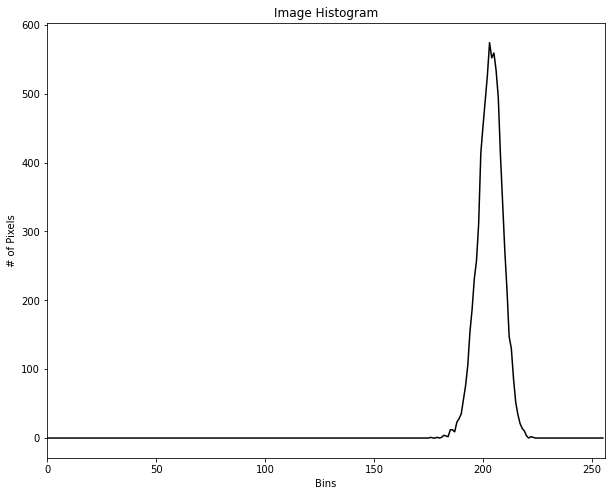

In [71]:
# Histogram for Grayscale Image
plot_frame_histogram({'images': [gray], 'mask': mask_circle})

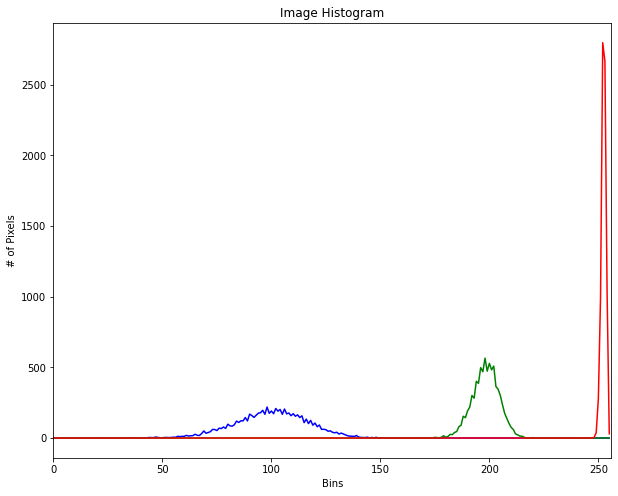

In [72]:
plot_frame_histogram({'images': [img_resize], 'channels': [0, 1, 2], 'mask': mask_circle}, {'channel_colors': ['b', 'g', 'r']})

### 24. Adaptive Thresholding of an Image

In [73]:
athresh_maxval = 255
athresh_adamethod = cv.ADAPTIVE_THRESH_MEAN_C
#athresh_adamethod = cv.ADAPTIVE_THRESH_GAUSSIAN_C
athresh_thrmethod = cv.THRESH_BINARY
athresh_blocksize = 11
athresh_c = 0
adaptive_thresh = cv.adaptiveThreshold(gray, athresh_maxval, athresh_adamethod, athresh_thrmethod, athresh_blocksize, athresh_c)

In [74]:
show_frame(adaptive_thresh, "Adaptive Thresholded Sun Image")

### 25. Edge Detection in an Image (cont)

In [75]:
# Laplacian
lap_ddepth = cv.CV_64F
lap = cv.Laplacian(gray, lap_ddepth)
lap = np.uint8(np.absolute(lap))

In [76]:
show_frame(lap, "Laplacian of Sun Image")

In [77]:
# Sobel
sob_ddep = cv.CV_64F
sobelx = cv.Sobel(gray, sob_ddep, 1, 0)
sobely = cv.Sobel(gray, sob_ddep, 0, 1)

In [78]:
show_frame(sobelx, "Sobel X of Sun Image")

In [79]:
show_frame(sobely, "Sobel Y of Sun Image")

In [80]:
combined_sobel = cv.bitwise_or(sobelx, sobely)
show_frame(combined_sobel, "Combined Sobel of Sun Image")